<a href="https://colab.research.google.com/github/annacrosby12/PHYS243/blob/master/Professional_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import  pandas as pd 
dataframe = pd.read_csv('https://raw.githubusercontent.com/jeffheaton/aifh/master/vol1/python-examples/datasets/breast-cancer-wisconsin.csv', engine='python') 
dataframe = dataframe.drop(['id'], axis=1) 
#print(dataframe.describe()) 
print(dataframe[:5])

   clump_thickness  size_uniformity  ...  mitoses  class
0                5                1  ...        1      2
1                5                4  ...        1      2
2                3                1  ...        1      2
3                6                8  ...        1      2
4                4                1  ...        1      2

[5 rows x 10 columns]


In [0]:
#handling na 
for label in ['clump_thickness','size_uniformity','shape_uniformity','marginal_adhesion']: 
    dataframe[label] = dataframe[label].fillna(method='ffill') 


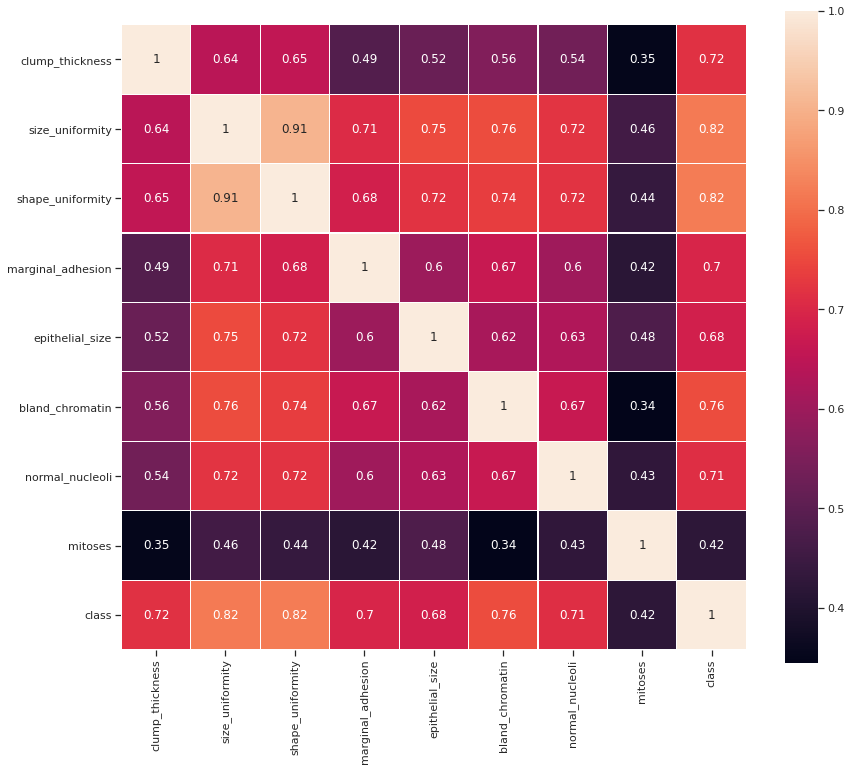

In [90]:
## To check the correlativity between attributes    
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.set(style='ticks', color_codes=True) 
plt.figure(figsize=(14, 12)) 

sns.heatmap(dataframe.corr(),  
             linewidths=0.1,  
             square=True,  
             linecolor='white',  
             annot=True) 
plt.show()

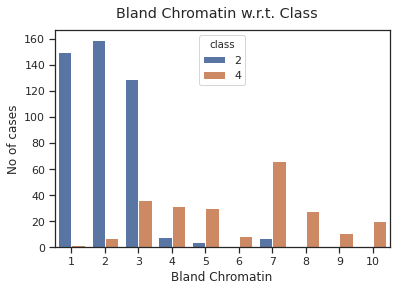

In [91]:
##Bar plot 1  
fig = plt.figure() 
x = sns.countplot(x='bland_chromatin',  
                  hue='class',  
                  #palette={0:'#EB434A', 1:'#61A98F'},  
                  data=dataframe) 
x.set(xlabel='Bland Chromatin', ylabel='No of cases') 
fig.suptitle("Bland Chromatin w.r.t. Class", y=0.96); 

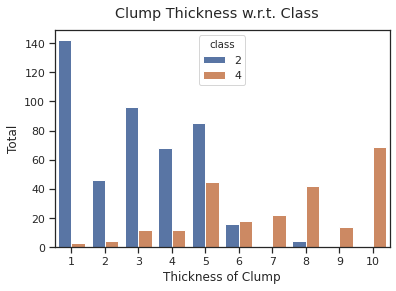

In [92]:
##Bar plot 2  
fig = plt.figure() 
x = sns.countplot(x='clump_thickness',  
                    hue='class',  
                    #palette={0:'#EB434A', 1:'#61A98F'},  
                    data=dataframe) 
x.set(xlabel='Thickness of Clump', ylabel='Total') 
fig.suptitle("Clump Thickness w.r.t. Class", y=0.96); 

In [0]:
#Model will be predicting thickness of clump

from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf

In [0]:
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 15
pd.options.display.float_format = '{:.1f}'.format

In [0]:
dataframe = dataframe.reindex(
    np.random.permutation(dataframe.index))

In [0]:
def preprocess_features(dataframe):
  """Prepares input features from Wisconsin breast cancer data set.

  Args:
    dataframe: A Pandas DataFrame expected to contain data
      from the Wisconsin breast cancer data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = dataframe[
    ["size_uniformity",
     "shape_uniformity",
     "marginal_adhesion",
     "epithelial_size",
     "bland_chromatin",
     "normal_nucleoli",
     "mitoses",
     "class"]]
  processed_features = selected_features.copy()
  return processed_features

In [0]:
def preprocess_targets(dataframe):
  """Prepares target features (i.e., labels) from data set.

  Args:
    dataframe: A Pandas DataFrame expected to contain data
      from the Wisconsin breast cancer data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets["clump_thickness"] = (
    dataframe["clump_thickness"])
  return output_targets

In [0]:
# 300 of 569 instances go into the training set

training_examples = preprocess_features(dataframe.head(300))
training_targets = preprocess_targets(dataframe.head(300))

# 269 of 569 instances go into the test set for validation
validation_examples = preprocess_features(dataframe.tail(269))
validation_targets = preprocess_targets(dataframe.tail(269))

In [99]:
# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

Training examples summary:


,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bland_chromatin,normal_nucleoli,mitoses,class
count,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
mean,3.0,3.0,2.7,3.1,3.4,2.8,1.5,2.7
std,2.9,2.8,2.7,2.1,2.5,3.0,1.6,0.9
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
25%,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0
50%,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0
75%,4.0,5.0,3.0,4.0,5.0,3.0,1.0,4.0
max,10.0,10.0,10.0,10.0,10.0,10.0,10.0,4.0


Validation examples summary:


,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bland_chromatin,normal_nucleoli,mitoses,class
count,269.0,269.0,269.0,269.0,269.0,269.0,269.0,269.0
mean,3.2,3.3,2.9,3.3,3.5,3.0,1.6,2.7
std,3.1,3.1,3.0,2.3,2.3,3.1,1.7,1.0
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
25%,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0
50%,1.0,2.0,1.0,2.0,3.0,1.0,1.0,2.0
75%,5.0,5.0,4.0,4.0,4.0,4.0,1.0,4.0
max,10.0,10.0,10.0,10.0,10.0,10.0,10.0,4.0


In [100]:
print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training targets summary:


,clump_thickness
count,300.0
mean,4.4
std,2.8
min,1.0
25%,2.0
50%,4.0
75%,5.2
max,10.0


Validation targets summary:


,clump_thickness
count,269.0
mean,4.4
std,2.9
min,1.0
25%,2.0
50%,4.0
75%,6.0
max,10.0


In [0]:
#PICK UP HERE

def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in training_examples])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

  # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels    

In [0]:
#PICK UP HERE

def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  
  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )

  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["clump_thickness"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["clump_thickness"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["clump_thickness"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )

    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

In [104]:
training_examples.dtypes

size_uniformity      int64
shape_uniformity     int64
marginal_adhesion    int64
epithelial_size      int64
bland_chromatin      int64
normal_nucleoli      int64
mitoses              int64
class                int64
dtype: object

Training model...
RMSE (on training data):
  period 00 : 2.20
  period 01 : 2.11
  period 02 : 2.02
  period 03 : 2.05
  period 04 : 2.16
  period 05 : 2.14
  period 06 : 2.12
  period 07 : 2.10
  period 08 : 2.09
  period 09 : 2.07
Model training finished.
Final RMSE (on training data):   2.07
Final RMSE (on validation data): 2.26


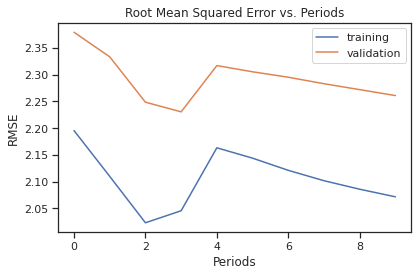

In [105]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [106]:
test_examples = preprocess_features(dataframe)
test_targets = preprocess_targets(dataframe)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["clump_thickness"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 2.17
